# Beamforming over trajectory

This script is an example of use of InverseMethods library using time domain generated signal simulated using the Simulations library.

--Moving source with rotations considered--

In [3]:
from cleantipy.InverseMethods import Beamforming_t_traj
import numpy as np
import pylab as pl
from Sarradj_2016_array import MicArrayGeom
from cleantipy.Propagation import MovingSrcSimu_t
import scipy.io as io

## Setting up the parameters

In [9]:
#%% Parameters

# Set to "True" if forcing recomputation is needed
compute = False

pref = 2*10**-5 #Pa
fs = 10000
T = 3
Nt = int(fs*T)
t = np.arange(T*fs)/fs 


fs_traj = 4 # 4 GPS points per seceonds
# fs_traj = fs # same as time samplerate
Nt_ = T*fs_traj+1
t_traj = np.arange(Nt_)/fs_traj

In [10]:
# Angles setup
ang = np.array([(1-np.cos(t_traj/2))/2,0*t_traj,-(1-np.cos(t_traj/2))/3]).T


# Trajectory setup
v = 100   # m/s
Z = 150 # m
Y = 0   # m
X = np.arange(Nt_)*v/fs_traj - T*v/2    # m
traj = np.array([X,Y*np.ones(Nt_),Z*np.ones(Nt_)]).T

# Adding rotations
traj += np.array([0*np.arange(Nt_),-(1-np.cos(t_traj/2))*180/np.pi,0*np.arange(Nt_)]).T


# Micropophone array geometry setup
Nmic = 256
x, y = MicArrayGeom(Nmic,h=2)
z_array = 0

geom = np.array([x,y,z_array*np.ones((Nmic))]).T

In [11]:
# Source definition (position and signal)
sig = np.array([np.random.randn(Nt), # white noise
                np.sin(2*np.pi*440*2*t), # 880 Hz sine
                np.sin(2*np.pi*440*t)]) # 440 Hz sine
pos = np.array([[10,0,0],
                [0,10,0],
                [0,-10,0]]) # relative position to the trajectory

## Runing or loading simulation

In [ ]:
# Define simulation object
simu = MovingSrcSimu_t(geom, pos, traj, t, sig, t_traj=t_traj, angles=ang, SNR=60, timeOrigin='source')


simu.plot()
ax = pl.gca()        
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)


#%% Compute simulated pressures
if compute: 
    try:
        print("** Computing microphone signals **")
        simu.compute(parrallel=True,interpolation="quadratic")
        Sig = simu.p_t
        io.savemat('SimuAngles.mat',{'Sig':Sig})
    except :
        tmp = io.loadmat('SimuAngles.mat',variable_names=['Sig'])
        Sig = tmp['Sig']

else:
    try:
        tmp = io.loadmat('SimuAngles.mat',variable_names=['Sig'])
        Sig = tmp['Sig']
    except :
        print("** SimuAngles.mat not found: Computing microphone signals **")
        simu.compute(parrallel=True,interpolation="quadratic")
        Sig = simu.p_t
        io.savemat('SimuAngles.mat',{'Sig':Sig})


# Check Dopplerization
pl.figure()
pl.specgram(Sig[0,:],2048,fs,noverlap=1024)

# Check Dopplerization
pl.figure()
pl.plot(Sig[0,:])

del simu

## Run the Delay-and-Sum Beamforming

### Beamforming on one point (the source location)



****************************************************
** Beamforming on one point (the source location) **
****************************************************


C:\Users\leiba\AppData\Local\Temp\ipykernel_23476\1142181508.py:20: MatplotlibDeprecationWarning: Passing the NFFT parameter of specgram() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  tmp = pl.specgram(bf_t.BF_t[0,:],2048,fs,noverlap=1024,vmin=-20*np.log10(2)-100)
c:\Users\leiba\Documents\CleanTiPy\.venv\Lib\site-packages\matplotlib\axes\_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


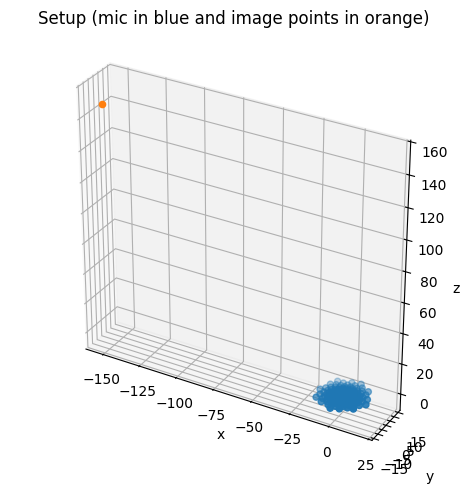

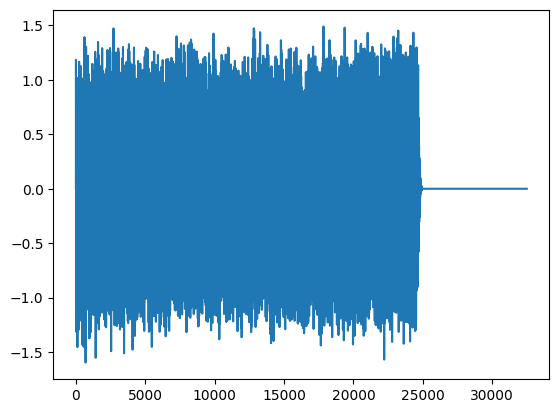

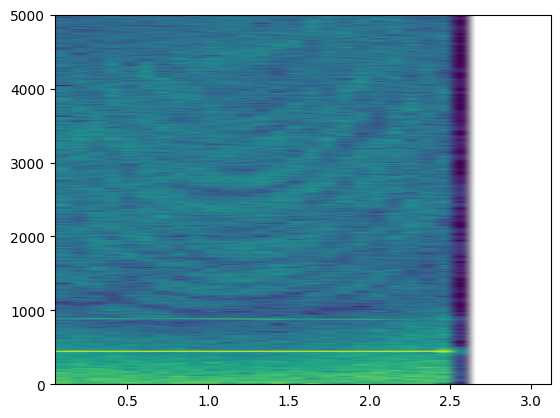

In [ ]:
#%% Define and compute the Beamforming on one point (a source location)
print('\n')
print(52*'*')
print("** Beamforming on one point (the source location) **")
print(52*'*')

bf_t = Beamforming_t_traj(geom,np.array([pos[2,:]]),traj,t,Sig,ang,t_traj)

bf_t.plot()
ax=pl.gca()
ax.set_aspect('equal')

bf_t.compute(parrallel=True, interpolation='quadratic')

# Check de-Dopplerization
pl.figure()
pl.plot(bf_t.BF_t[0,:])

pl.figure()
tmp = pl.specgram(bf_t.BF_t[0,:],2048,fs,noverlap=1024,vmin=-20*np.log10(2)-100)

### Beamforming on a grid



******************************************************
** Beamforming on the grid following the trajectory **
******************************************************


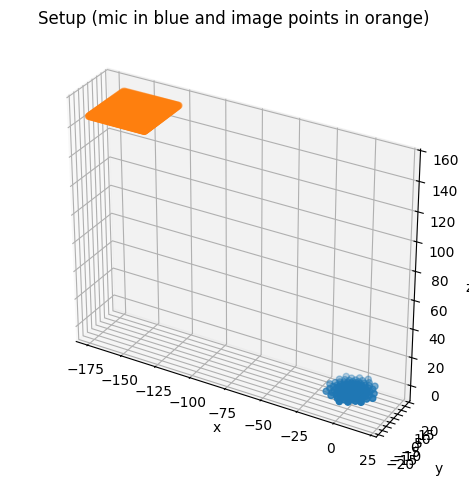

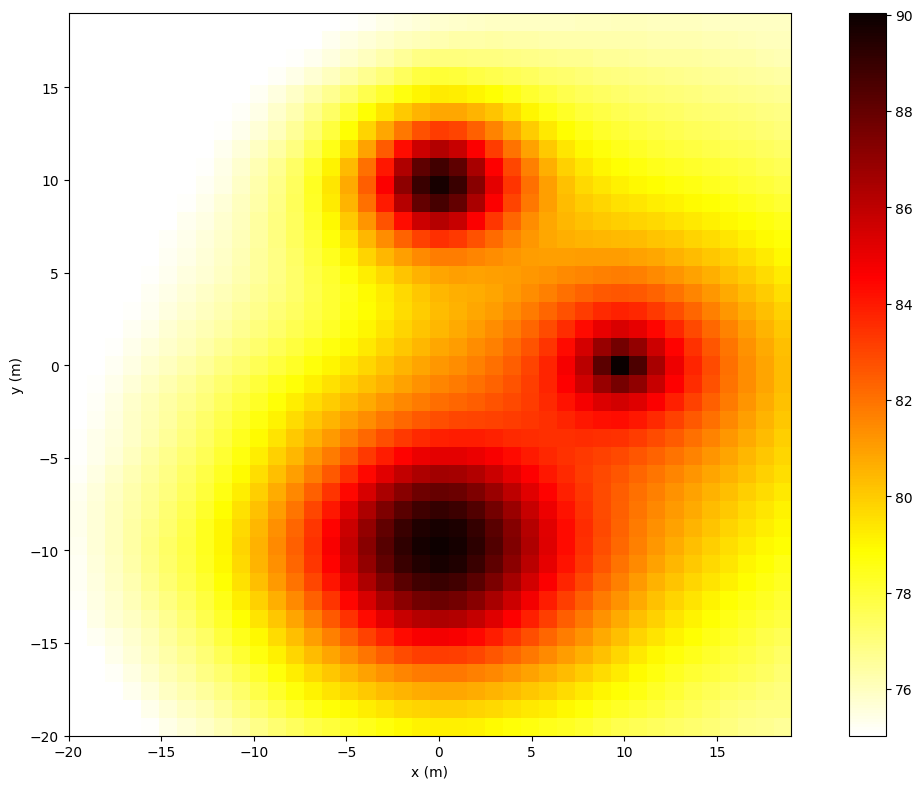

In [ ]:
#%% define image plan relatively to the trajectory
print('\n')
print(54*'*')
print("** Beamforming on the grid following the trajectory **")
print(54*'*')

Lx = 40
Ly = 40
x_F = np.arange(0,Lx,1)-Lx/2
y_F = np.arange(0,Ly,1)-Ly/2
z_F = 0 
X_F, Y_F, Z_F = np.meshgrid(x_F,y_F,z_F)
grid = np.array([X_F.reshape(-1),Y_F.reshape(-1),Z_F.reshape(-1)]).T


#%% Define and compute the Beamforming on a grid
bf_t = Beamforming_t_traj(geom,grid,traj,t,Sig,ang,t_traj)

bf_t.plot()
ax=pl.gca()
ax.set_aspect('equal')

bf_t.compute(parrallel=True)


#%% Display results on grid along the trajectory
fig = pl.figure(figsize=(12,8))
BF_dB = (20*np.log10(np.std(bf_t.BF_t,axis=1)/pref)).reshape((y_F.size,x_F.size))        
mx = np.max(BF_dB)
pl.imshow(BF_dB, vmax=mx, vmin=mx-15, \
        origin='lower',cmap='hot_r',\
            extent=[x_F[0],x_F[-1],y_F[0],y_F[-1]])
pl.ylabel('y (m)')
pl.colorbar()
pl.xlabel('x (m)')
pl.tight_layout()

pl.show()